1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

-0.9995999999999999
-0.9995999999999999
-1.0275430362121565
Minimum 1 : -1.0316284534898772 reached in [ 0.08984201 -0.71265641]
Minimum 2 : -1.0316284534898772 reached in [-0.08984202  0.71265641]
Minimum found : -1.0316284534898774 reached in [ 0.08984201 -0.7126564 ]


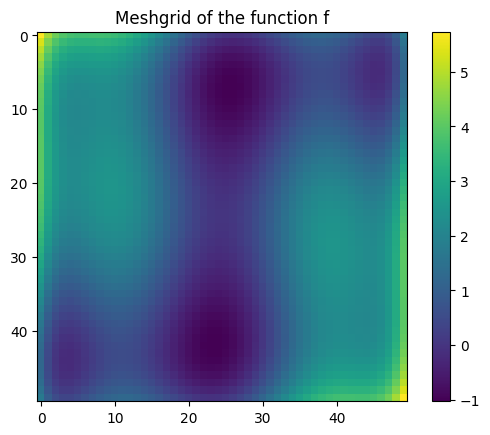

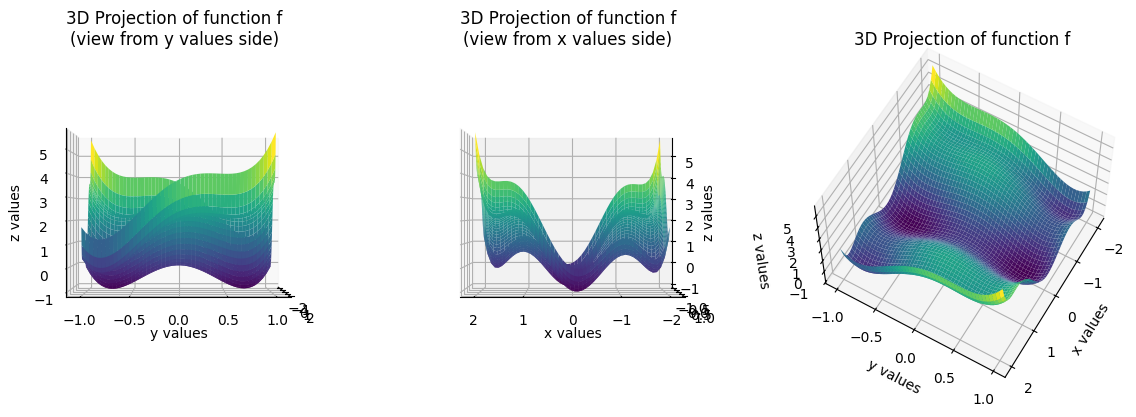

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping


nValues=50

def f(param):
    x,y = param
    return (4-2.1*x**2+(x**4)/3)*x**2+x*y+(4*y**2-4)*y**2

xValues = np.linspace(-2,2,nValues)
yValues = np.linspace(-1,1,nValues)

x,y = np.meshgrid(xValues,yValues)
z = f((x,y))
plt.figure()
plt.imshow(z)
plt.colorbar()
plt.title("Meshgrid of the function f")
plt.plot()

figure = plt.figure(figsize=(plt.figaspect(1/3)))
ax=figure.add_subplot(1,3,1,projection="3d")
ax.view_init(0, 0)
ax.plot_surface(x,y,z,cmap='viridis',edgecolor='none')
ax.set_title("3D Projection of function f\n(view from y values side)")
# ax.set_xlabel("x values")
ax.set_ylabel("y values")
ax.set_zlabel("z values")

ax=figure.add_subplot(1,3,2,projection="3d")
ax.view_init(0, 90)
ax.plot_surface(x,y,z,cmap='viridis',edgecolor='none')
ax.set_title("3D Projection of function f\n(view from x values side)")
ax.set_xlabel("x values")
# ax.set_ylabel("y values")
ax.set_zlabel("z values")

ax=figure.add_subplot(1,3,3,projection="3d")
ax.view_init(60, 30)
ax.plot_surface(x,y,z,cmap='viridis',edgecolor='none')
ax.set_title("3D Projection of function f")
ax.set_xlabel("x values")
ax.set_ylabel("y values")
ax.set_zlabel("z values")

# Minima should appear around (x,y)=(0,-0.7) and (0,0.7)
var_1 = [0,-0.7]
var_2 = [0,0.7]
print(f(var_1))
print(f(var_2))
print(z.min())

# Optimization
result = basinhopping(f, var_1, stepsize=0.1)
xyValues_1 = result['x']
value_1 = f(xyValues_1)

result = basinhopping(f, var_2, stepsize=0.1)
xyValues_2 = result['x']
value_2 = f(xyValues_2)

print("Minimum 1 :",value_1,"reached in",xyValues_1)
print("Minimum 2 :",value_2,"reached in",xyValues_2)

# Start with (0,0)
x_0 = (0,0)
result = basinhopping(f, x_0, stepsize=0.1)
xyValues_0 = result['x']
value_0 = f(xyValues_0)
print("Minimum found :",value_0,"reached in",xyValues_0)


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

[]

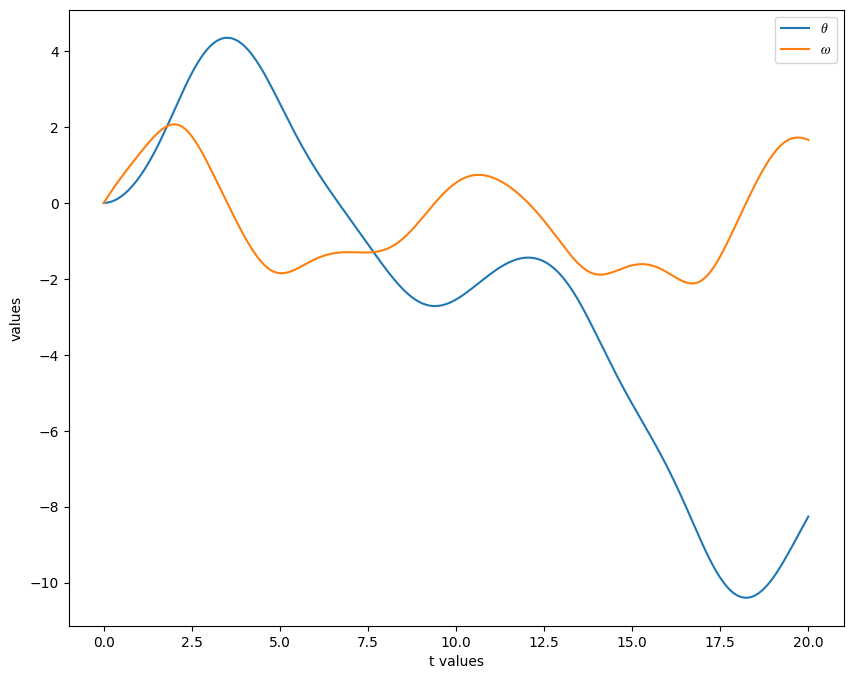

In [108]:
from math import sin,cos
from scipy.integrate import odeint

g = 9.81 # No value for g, I assume g = 9.81
Q = 2.0
d = 1.5
omega = 0.65 # Could be an error in the exercice, as written 𝜔, but I assume it's for 𝜃
l = 10

def derivate(xValues,t):
    # xValues = [x,x']
    return (xValues[1],-(1/Q)*xValues[1]+(g/l)*sin(xValues[0])+d*cos(omega*t))

x_init = [0,0]
t = np.linspace(0,20,200)
result = odeint(derivate,x_init,t)

plt.figure(figsize=(10,8))
plt.plot(t,result[:,0],label="$𝜃$")
plt.plot(t,result[:,1],label="$𝜔$")
plt.xlabel('t values')
plt.ylabel('values')
plt.legend()
plt.plot()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

10.5
10.5
10.5


Text(0.5, 1.0, 'Original data & filtered signals')

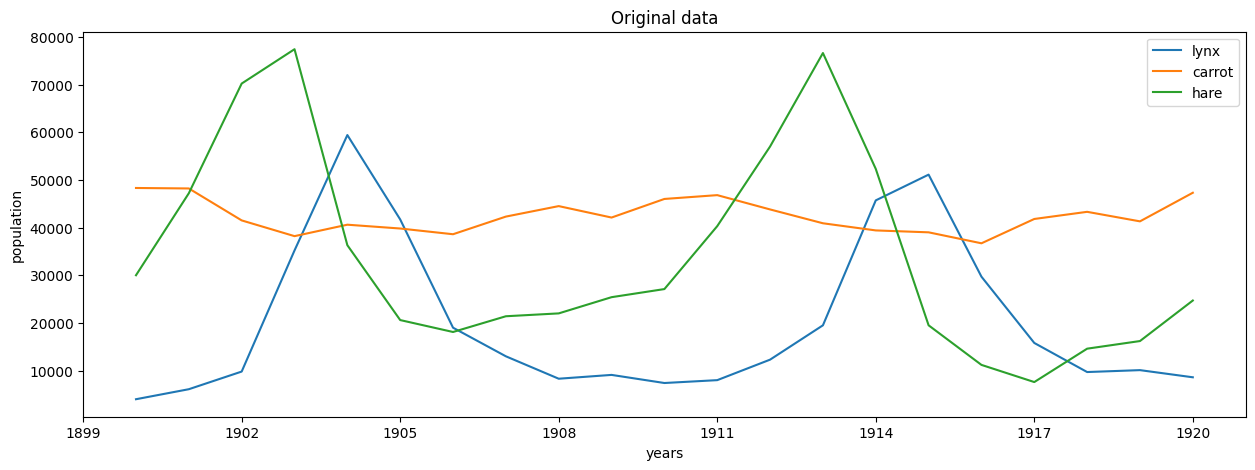

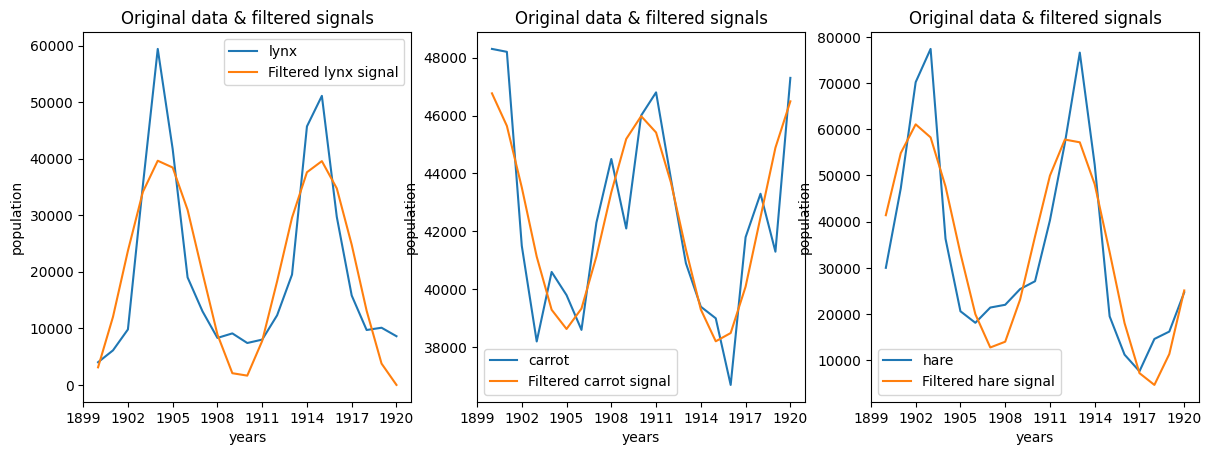

In [134]:
import pandas as pd
from scipy import fftpack
from matplotlib.ticker import MaxNLocator

dataFrame = pd.read_csv("data/populations.txt", delimiter="\t")
# print(dataFrame)

time = dataFrame["# year"].values
lynx = dataFrame["lynx"].values
carrot = dataFrame["carrot"].values
hare = dataFrame["hare"].values

plt.figure(figsize=(15, 5))

plt.plot(time, lynx, label="lynx")
plt.plot(time, carrot, label="carrot")
plt.plot(time, hare, label="hare")

plt.legend()
plt.xlabel("years")
plt.ylabel("population")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Original data")
plt.plot()


def peakPop(animal):
    fftAnimal = fftpack.fft(animal)
    freq = fftpack.fftfreq(len(fftAnimal), 1)
    freq = freq[freq > 0]
    periodAnimal = 1 / np.abs(freq[np.argmax(fftAnimal) + 1])
    return periodAnimal


peakLynx = peakPop(lynx)
print(peakLynx)
peakHare = peakPop(hare)
print(peakHare)
peakCarrot = peakPop(carrot)
print(peakCarrot)


def periodicSignal(animal):
    fftAnimal = fftpack.fft(animal)
    freq = fftpack.fftfreq(len(fftAnimal), 1)
    fftAnimal[np.abs(freq) - 1 / peakPop(animal) > 0] = 0
    filteredfft = np.real(fftpack.ifft(fftAnimal))
    return filteredfft


filterdLynx = periodicSignal(lynx)
filterdCarrot = periodicSignal(carrot)
filterdHare = periodicSignal(hare)

figure = plt.figure(figsize=(plt.figaspect(1/3)))
ax = figure.add_subplot(1, 3, 1)
ax.plot(time, lynx, label="lynx")
ax.plot(time, filterdLynx, label="Filtered lynx signal")
plt.legend()
plt.xlabel("years")
plt.ylabel("population")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Original data & filtered signals")

ax = figure.add_subplot(1, 3, 2)
plt.plot(time, carrot, label="carrot")
plt.plot(time, filterdCarrot, label="Filtered carrot signal")
plt.legend()
plt.xlabel("years")
plt.ylabel("population")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Original data & filtered signals")

ax = figure.add_subplot(1, 3, 3)
plt.plot(time, hare, label="hare")
plt.plot(time, filterdHare, label="Filtered hare signal")
plt.legend()
plt.xlabel("years")
plt.ylabel("population")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Original data & filtered signals")

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Filtered image')

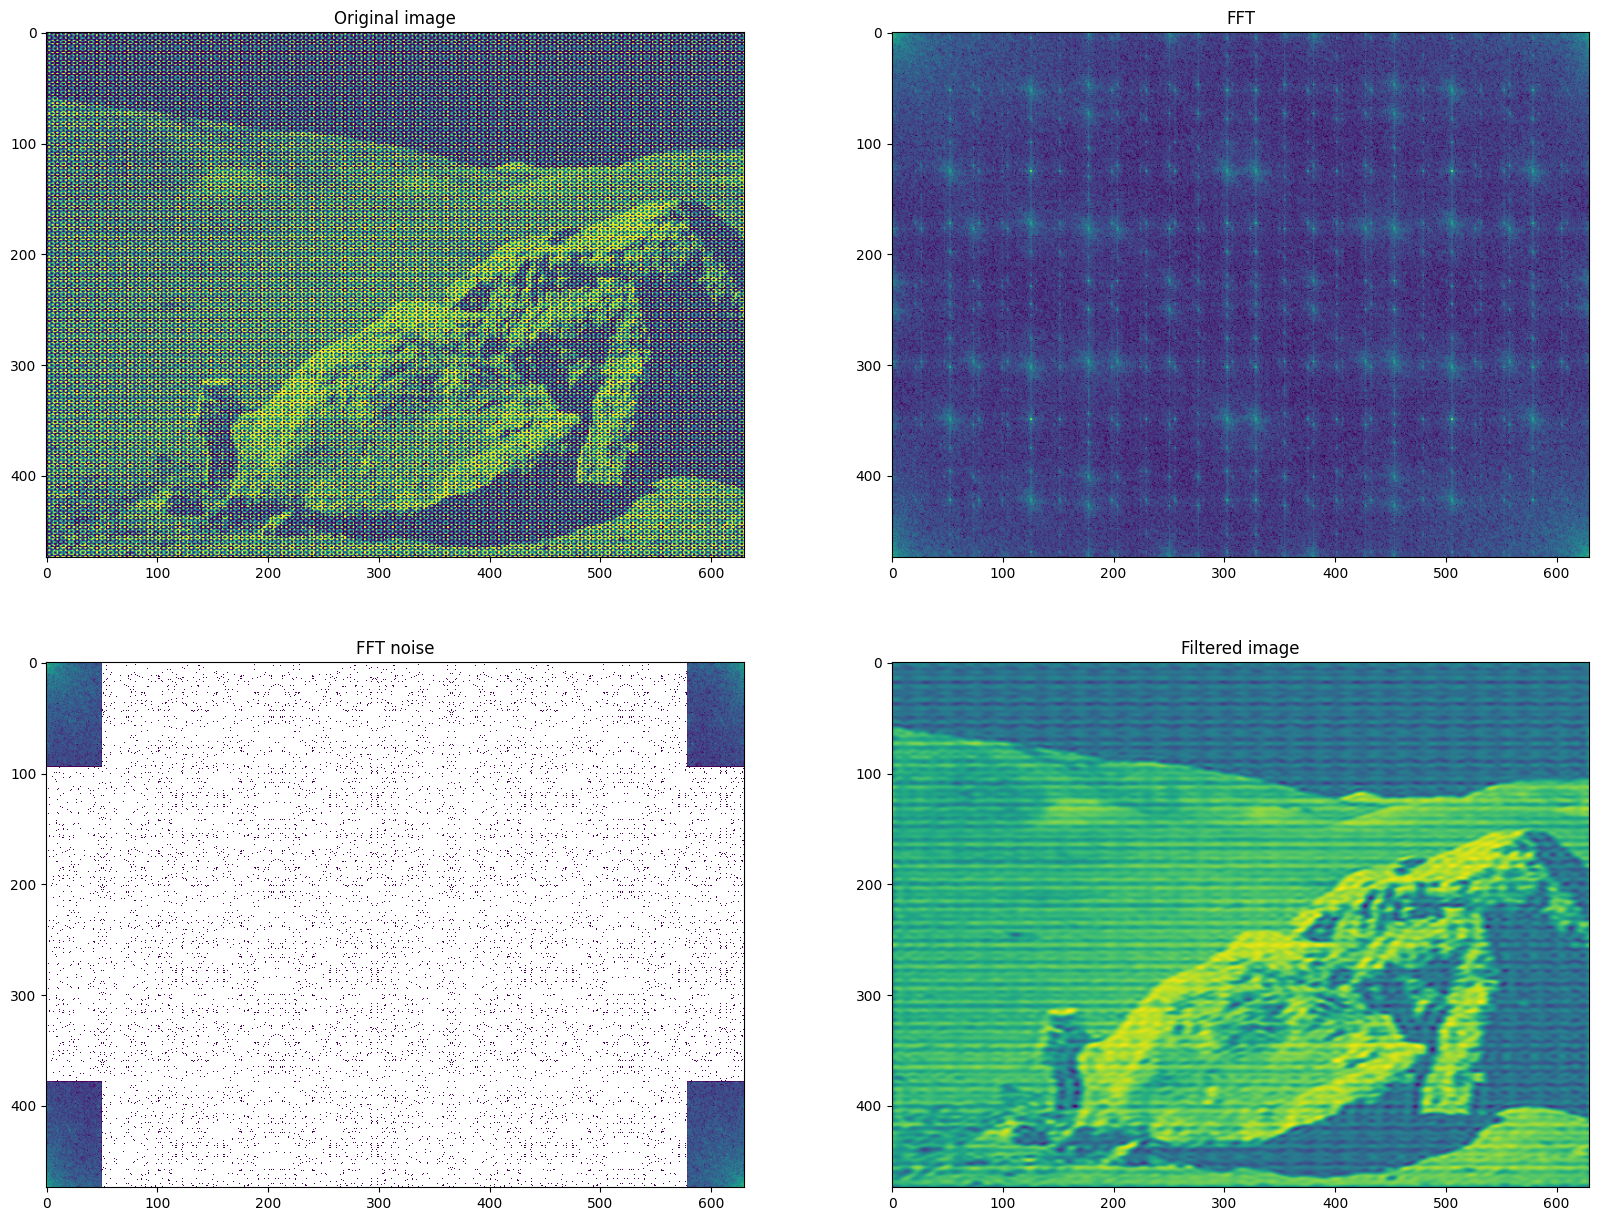

In [213]:
from matplotlib.colors import LogNorm

figure = plt.figure(figsize=(20,15))

image = plt.imread("images/moonlanding.png")
ax = figure.add_subplot(2, 2, 1)
ax.imshow(image)
ax.set_title("Original image")

fftImage = np.abs(fftpack.fft2(image))
ax = figure.add_subplot(2, 2, 2)
ax.imshow(fftImage,norm=LogNorm(vmin=5))
ax.set_title("FFT")

fftImage = fftpack.fft2(image)
row,col = fftImage.shape
fftImage[int(row*.2):int(row*.8),:]=0
fftImage[:,int(col*.08):int(col*.92)]=0
ax = figure.add_subplot(2,2,3)
ax.imshow(np.abs(fftImage),norm=LogNorm(vmin=5))
ax.set_title("FFT noise")

fftImage = np.real(fftpack.ifft2(fftImage))
ax = figure.add_subplot(2,2,4)
ax.imshow(fftImage,norm=LogNorm())
ax.set_title("Filtered image")